# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [21]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from collections import Counter
import ast
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [22]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
len_azdias = len(azdias)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [23]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [24]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [25]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,NATIONALITAET_KZ,person,ordinal,[-1]
freq,1,43,49,26


In [26]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [27]:
# Generating lists for each variable type
categorical_names = []
interval_names = []
numeric_names = []
mixed_names = []

for i in range(feat_info.shape[0]):
    if feat_info['type'][i] == 'numeric':
        numeric_names.append(feat_info['attribute'][i])
    if feat_info['type'][i] == 'interval':
        interval_names.append(feat_info['attribute'][i])
    if feat_info['type'][i] == 'mixed':
        mixed_names.append(feat_info['attribute'][i])
    if feat_info['type'][i] == 'categorical':
        categorical_names.append(feat_info['attribute'][i])
        
print(f"Categorical type variables:\n{categorical_names}\n")
print(f"Interval type variables:\n{interval_names}\n")
print(f"Mixed type variables:\n{mixed_names}\n")
print(f"Numeric type variables:\n{numeric_names}")

Categorical type variables:
['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Interval type variables:
['ALTER_HH']

Mixed type variables:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']

Numeric type variables:
['GEBURTSJAHR', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW']


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [28]:
azdias.isnull().sum().sum()

4896838

In [29]:
# Checking feature info file for missing values
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [30]:
# Replacing chars as strings
feat_info['m_or_u_list'] = feat_info['missing_or_unknown']

for i in  range(len(feat_info['m_or_u_list'])):
    feat_info['m_or_u_list'][i] = feat_info['m_or_u_list'][i]\
                                  .replace('XX', 'yy')
    feat_info['m_or_u_list'][i] = feat_info['m_or_u_list'][i]\
                                  .replace('X', ' "X" ')
    feat_info['m_or_u_list'][i] = feat_info['m_or_u_list'][i]\
                                  .replace('yy', ' "XX" ')

feat_info['m_or_u_list'] = feat_info['m_or_u_list'].map(ast.literal_eval)


In [31]:
# Checking replacement worked correctly
print(f"before: {feat_info['missing_or_unknown'][57]}")
print(f"after: {feat_info['m_or_u_list'][57]}")

feat_info.loc[50:60,:]



before: [-1,X]
after: [-1, 'X']


,attribute,information_level,type,missing_or_unknown,m_or_u_list
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],[0]
51,ANZ_HH_TITEL,building,numeric,[],[]
52,GEBAEUDETYP,building,categorical,"[-1,0]","[-1, 0]"
53,KONSUMNAEHE,building,ordinal,[],[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0],[0]
55,OST_WEST_KZ,building,categorical,[-1],[-1]
56,WOHNLAGE,building,mixed,[-1],[-1]
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]","[-1, X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX],[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"


In [32]:


# Checking that column names mactch between files
for i in range(len(azdias.columns)):
    counter = 0
    if azdias.columns[i] != feat_info['attribute'][i]:
        print("column names do not match")
        print(f"azdias: {azdias.columns[i]}")
        print(f"feat_info: {feat_info['attribute'][i]}")
        counter += 1

if counter == 0:
    print("All columns match")
else:
    print("Columns do not match")



All columns match


In [33]:
# Replacing unknown/missing codes with NaN values
for i in range(len(azdias.columns)):
    if feat_info['m_or_u_list'][i] != []:
        azdias.iloc[:, i] = azdias.iloc[:, i]\
                            .replace(feat_info['m_or_u_list'][i], np.nan)
    else:
        continue

In [34]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [35]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_list = azdias.isnull().sum()
null_per = null_list / len(azdias) * 100
null_per[null_per > 20]


AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

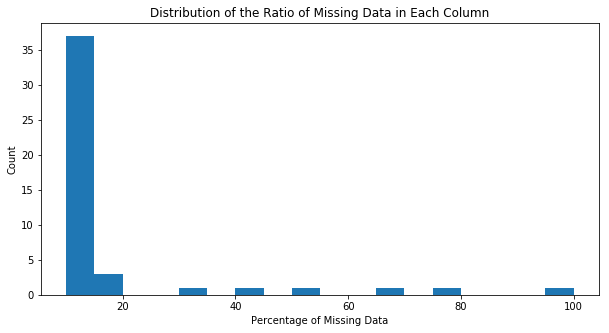

In [36]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_per, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()


In [37]:
azdias.isnull().sum().describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [38]:

# Quantile for no. NaN values <= 200,000
stats.percentileofscore(azdias.isnull().sum(),200000)

92.941176470588232

In [39]:
# Finding largest outlier
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 800000:
        print(azdias.columns[i])
     


TITEL_KZ


In [40]:
azdias.loc[:,'TITEL_KZ'].isnull().sum()    

889061

In [41]:
outliers = []
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 200000:
        outliers.append(azdias.columns[i])

In [42]:
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [43]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(outliers, axis=1, inplace=True)
azdias.shape


(891221, 79)

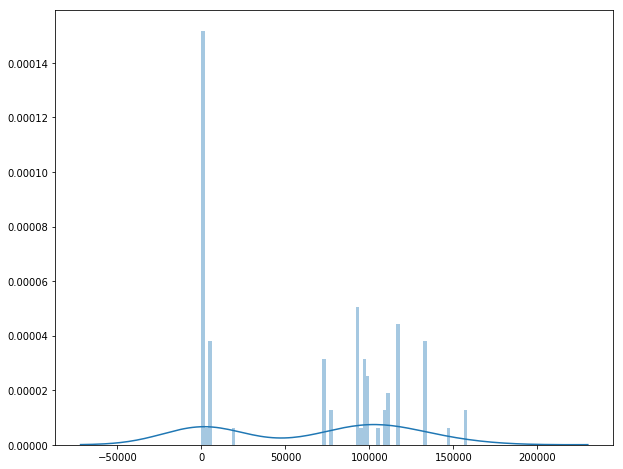

In [44]:
fig, ax = plt.subplots(figsize = (10,8))
sns.distplot(azdias.isnull().sum(), bins = 79, ax = ax)
plt.show()

In [45]:
# Columns containing no null values
for i in range(azdias.shape[1]):
    if azdias.iloc[:,i].isnull().sum() == 0:
        print(f"{azdias.columns[i]}")

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


In [46]:
# Investigate patterns in the amount of missing data in each column.
d={}
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 0:
        print(f"{azdias.columns[i]}:  {azdias.iloc[:,i].isnull().sum()}")
        d[azdias.columns[i]] = azdias.iloc[:, i].isnull().sum()

ALTERSKATEGORIE_GROB:  2881
CJT_GESAMTTYP:  4854
GFK_URLAUBERTYP:  4854
HEALTH_TYP:  111196
LP_LEBENSPHASE_FEIN:  97632
LP_LEBENSPHASE_GROB:  94572
LP_FAMILIE_FEIN:  77792
LP_FAMILIE_GROB:  77792
LP_STATUS_FEIN:  4854
LP_STATUS_GROB:  4854
NATIONALITAET_KZ:  108315
PRAEGENDE_JUGENDJAHRE:  108164
RETOURTYP_BK_S:  4854
SHOPPER_TYP:  111196
SOHO_KZ:  73499
VERS_TYP:  111196
ANZ_PERSONEN:  73499
ANZ_TITEL:  73499
HH_EINKOMMEN_SCORE:  18348
W_KEIT_KIND_HH:  147988
WOHNDAUER_2008:  73499
ANZ_HAUSHALTE_AKTIV:  99611
ANZ_HH_TITEL:  97008
GEBAEUDETYP:  93148
KONSUMNAEHE:  73969
MIN_GEBAEUDEJAHR:  93148
OST_WEST_KZ:  93148
WOHNLAGE:  93148
CAMEO_DEUG_2015:  99352
CAMEO_DEU_2015:  99352
CAMEO_INTL_2015:  99352
KBA05_ANTG1:  133324
KBA05_ANTG2:  133324
KBA05_ANTG3:  133324
KBA05_ANTG4:  133324
KBA05_GBZ:  133324
BALLRAUM:  93740
EWDICHTE:  93740
INNENSTADT:  93740
GEBAEUDETYP_RASTER:  93155
KKK:  158064
MOBI_REGIO:  133324
ONLINE_AFFINITAET:  4854
REGIOTYP:  158064
KBA13_ANZAHL_PKW:  105800
PLZ8_A

In [47]:
# Grouping columns with same number of missing values

d_val_unique = set(d.values())

for i in d_val_unique:
    print(f"{[k for k,v in d.items() if v == i]} \n  {i}") 
    print()

['PRAEGENDE_JUGENDJAHRE'] 
  108164

['W_KEIT_KIND_HH'] 
  147988

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'] 
  99352

['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'] 
  73499

['ANZ_HAUSHALTE_AKTIV'] 
  99611

['NATIONALITAET_KZ'] 
  108315

['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'] 
  116515

['HH_EINKOMMEN_SCORE'] 
  18348

['BALLRAUM', 'EWDICHTE', 'INNENSTADT'] 
  93740

['ALTERSKATEGORIE_GROB'] 
  2881

['KBA13_ANZAHL_PKW'] 
  105800

['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO'] 
  133324

['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'] 
  93148

['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'] 
  111196

['ARBEIT', 'RELAT_AB'] 
  97375

['LP_LEBENSPHASE_FEIN'] 
  97632

['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'] 
  77792

['GEBAEUDETYP_RASTER'] 
  93155

['LP_LEBENSPHASE_GROB'] 
  94572

['ANZ_HH_TITEL'] 
  97008

['KONSUMNAEHE'] 
  73969

['KKK', 'REGIOT

#### Discussion 1.1.2: Assess Missing Data in Each Column

For the "Udacity_AZDIAS_Subset" dataset, an overview of the data shows that not all columns appear to contain 891,211 entries. The columns consist of 85 variables; 7 of these are classed as numeric, 1 classed as type "interval", 7 classed as "mixed", and the remaining 70 are categorical (49 of which are ordinal).
The numerical variables are:

    GEBURTSJAHR: Year of birth
    ANZ_PERSONEN: No. adults in household
    ANZ_TITEL: No. of professional title holders in household
    ANZ_HAUSHALTE_AKTIV: No. of households in building
    ANZ_HH_TITEL: No. of professional title holders in building
    MIN_GEBAEUDEJAHR: First year building was mentioned in the database
    KBA13_ANZAHL_PKW: No. cars in the PLZ8 region

Here, two variables are dealing with dates (GEBURTSJAHR and MIN_GEBAEUDEJAHR0 and therefore could potentially also be regarded as categorical. The variables labeled with type "interval" or "mixed" are also seen to have been encoded categorically.
Missing data

The total amount of missing data present in the dataset is approx. 11%. From looking at a histogram of the data for the NaN values, the vast majority of variables (approximately 92%) have less than 200,000 NaN entries. Therefore, I have considered outliers as variables with more than 200,000 NaN entries. Since there is a large fraction of variables remaining after removing outliers (79/85), and due to the fraction of missing values in the designated outliers being high, it is unlikely that too much significant information will be lost when removing these variables.
The identified and removed outliers are:

    AGER_TYP: Best-ager typology
    GEBURTSJAHR: Year of birth
    TITEL_KZ: Academic title flag
    ALTER_HH: Birthdate of head of household
    KK_KUNDENTYP: Consumer pattern over past 12 months
    KBA05_BAUMAX: Most common building type within the microcell

There is no immediately clear relation between these outliers. It may be worth nothing that two outliers (GEBURTSJAHR and ALTER_HH) involve the collection of dates. The variable with the largest number of NaN values is TITEL_KZ. This may be due to only a small proportion of the population hold an academic title, and not all of these people may wish to declare such a title.
Variables with no missing or unknown values:

    SEMIO...(x 14) :: Personality typology
    FINANZ...(x 7) : Financial typology
    ANREDE_KZ: Gender
    GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth
    ZABEOTYP: Energy consumption typology

The variables fall into two main groups: personality and financial typology. It is likely that values for these variables may be mandatory during collection. There is one exception, the variable GREEN_AVANTGARDE does not have a categorical level corresponding to "missing" or "unknown", meaning these values could not be collected (any NaN values, if present, would therefore likely be due to data handling).
Remaining variables containing missing or unknown values:

The remaining variables that do contain missing or unknown values are shown above, grouped by the amount of NaN values. By grouping them in such a way, it is clear that if one variable contains missing/unknown values, it will cause other related variables to record a missing/unknown value as well. For example, this can be seen for the PLZ8 macro-cell features, where seven of these features all contain 116515 NaN values. The same can be seen for postcode-level features, with all three features in the same grouping (BALLRAUM, EWDICHTE, and INNENSTADT). It is possible in some cases that the variables have been grouped by chance (SOHO_KZ and ANZ_PERSONEN), but this seems unlikely in most of the cases.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [48]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).describe()


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [49]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def subset_on_rows(dataframe, quant):
    cut_off = dataframe.isnull().sum(axis=1).quantile([quant]).tolist()
    
    above_c_o = dataframe[dataframe.isnull().sum(axis=1) > cut_off].copy()
    below_c_o = dataframe[dataframe.isnull().sum(axis=1) <= cut_off].copy()
    
    return above_c_o, below_c_o


In [50]:
azdias_more_nans, azdias_few_nans = subset_on_rows(azdias, 0.75)

print(f"No. rows in subset with few NaNs: {azdias_few_nans.shape[0]}")
print(f"No. rows in subset with more NaNs: {azdias_more_nans.shape[0]}")

No. rows in subset with few NaNs: 684502
No. rows in subset with more NaNs: 206719


In [51]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# Columns with no missing/unknown values
def good_columns(df):
    '''
    Returns list of columns from a dataframe which
    have no missing/unknown values.
    
    INPUT: Dataframe
    OUTPUT: List
    '''
    
    good_cols = []
    
    for i in range(df.shape[1]):
        if df.iloc[:,i].isnull().sum() == 0:
            good_cols.append(df.columns[i])
                
    return good_cols


In [52]:
# Creating subsets
more_nans_cols = good_columns(azdias_more_nans)
few_nans_cols = good_columns(azdias_few_nans)

# Columns in both subsets with no missing/unknown values:
good_columns_both = list(set(more_nans_cols).intersection(few_nans_cols))
print(good_columns_both)

['SEMIO_REL', 'ANREDE_KZ', 'SEMIO_VERT', 'SEMIO_ERL', 'FINANZ_SPARER', 'SEMIO_KULT', 'SEMIO_KRIT', 'SEMIO_PFLICHT', 'SEMIO_DOM', 'SEMIO_SOZ', 'GREEN_AVANTGARDE', 'FINANZTYP', 'FINANZ_HAUSBAUER', 'SEMIO_LUST', 'SEMIO_MAT', 'SEMIO_TRADV', 'ZABEOTYP', 'FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'SEMIO_FAM', 'SEMIO_RAT', 'SEMIO_KAEM', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER']


In [53]:
def comparison_plot(columns):
    '''
    Takes in categorical variables present in both
    dataframes and plots plots a bar of the levels
    in the variable for both data frames.
    
    INPUT: List
    OUTPUT: Figure
    '''
    
    num_rows = len(columns)
    
    fig, ax = plt.subplots(figsize=(20, 25), ncols= 2, nrows= num_rows, squeeze=False)
    
    ax[0][0].set_title("Many Missing Values Subset")
    ax[0][1].set_title("Few Missing Values Subset")
    
    for i in range(num_rows):
        sns.countplot(x=columns[i], data= azdias_more_nans,ax=ax[i][0])
        sns.countplot(x=columns[i], data= azdias_few_nans,ax=ax[i][1])

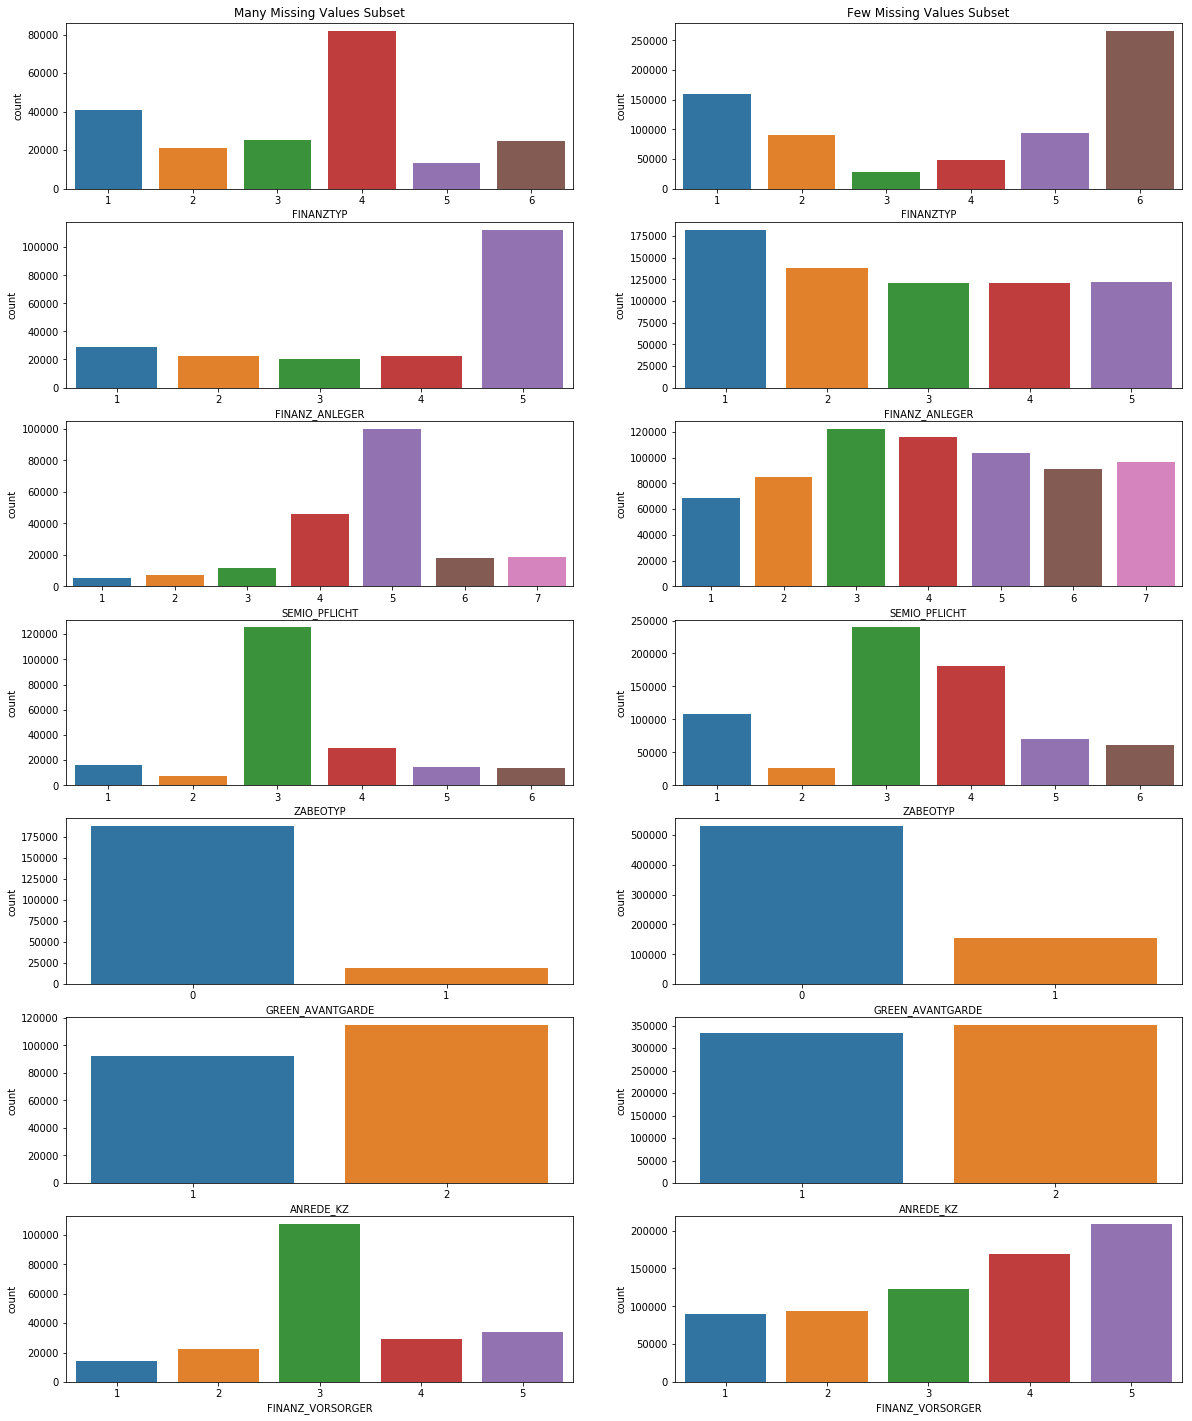

In [54]:
comparison_plot(["FINANZTYP", "FINANZ_ANLEGER", "SEMIO_PFLICHT", \
                 "ZABEOTYP", "GREEN_AVANTGARDE", "ANREDE_KZ", \
                 "FINANZ_VORSORGER"])

#### Discussion 1.1.3: Assess Missing Data in Each Row
Summay statistics

Summary statistics for the number of missing/unknown values across the rows were calculated. Therefore the mean and median number of NaN values was found to be 6 (rounding up) and 0 respectively. The difference in these values indicates there is likely some outlier rows with high amounts of NaN values.
Outier rows

I decided to use the third quartile as a guide for the cut-off for identifying outlier rows. This resulted in one subset containing rows with 3 NaN values or less, and the other subset containing rows with 4 or more NaN values.
Visual comparison

Columns that contained zero NaN values in both subsets were identified. By comparing one variable between two subsets, it is possible to see if both subsets present similar or distinct information about the population. In this case, seven different variables were compared. In the majority of cases there appears to be clear differences between the relative distributions of the subsets, i.e. clearly seen in the comparison of variables: FINANZTYP, FINANZ_ANLEGER, and SEMIO_PFLICHT.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [55]:
# How many features are there of each data type?
feat_info.groupby(by="type").size()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [56]:


for i,j in enumerate(categorical_names):
    print(j)



AGER_TYP
ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [57]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Finding binary categorical variables
binary_cols = []

for i, j in enumerate(categorical_names):
    
    if azdias_few_nans.columns.isin([categorical_names[i]]).sum() > 0:
        
        if len(set(azdias_few_nans[categorical_names[i]].values)) == 2:
            binary_cols.append(categorical_names[i])
        else:
            continue

binary_cols


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [58]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi_lvl_cols = []

for i,j in enumerate(categorical_names):
    
    if azdias_few_nans.columns.isin([categorical_names[i]]).sum() > 0:
        
        if len(set(azdias_few_nans[categorical_names[i]].values)) > 2:
            multi_lvl_cols.append(categorical_names[i])
        else:
            continue

multi_lvl_cols


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [59]:
# Re-encoding OST_WEST_KZ variable
azdias_few_nans['RE_OST_WEST_KZ'] = azdias_few_nans['OST_WEST_KZ']
mymap = {'W': 0, 'O': 1}
azdias_few_nans = azdias_few_nans.replace({'RE_OST_WEST_KZ': mymap})

# Checking re-encoding worked
azdias_few_nans.loc[123:124,['OST_WEST_KZ', 'RE_OST_WEST_KZ']]

,OST_WEST_KZ,RE_OST_WEST_KZ
123,W,0
124,W,0


In [60]:
# Dropping original OST_WEST_KZ column
azdias_few_nans.drop(['OST_WEST_KZ'], axis=1, inplace=True)
azdias_few_nans.shape

(684502, 79)

In [61]:
# One-hot-encoding multi-level categorical variables

# Converting possible numeric levels to strings for encoding
multi_cats_df = pd.DataFrame(azdias_few_nans[multi_lvl_cols], \
                             columns = multi_lvl_cols).astype(str)

# Finding NaNs that were converted to strings
(multi_cats_df == 'nan').sum()

CJT_GESAMTTYP          0
FINANZTYP              0
GFK_URLAUBERTYP        0
LP_FAMILIE_FEIN        0
LP_FAMILIE_GROB        0
LP_STATUS_FEIN         0
LP_STATUS_GROB         0
NATIONALITAET_KZ       0
SHOPPER_TYP            0
ZABEOTYP               0
GEBAEUDETYP            0
CAMEO_DEUG_2015     2639
CAMEO_DEU_2015      2639
dtype: int64

In [62]:
# Replacing str NaNs with true null values
multi_cats_df['CAMEO_DEUG_2015'] = multi_cats_df['CAMEO_DEUG_2015'].replace('nan', np.nan)
multi_cats_df['CAMEO_DEU_2015'] = multi_cats_df['CAMEO_DEU_2015'].replace('nan', np.nan)

# One-hot encoding
multi_cats_encoded = pd.get_dummies(multi_cats_df)
multi_cats_encoded.shape

(684502, 128)

In [63]:
# Dropping original multi-level categorical variables from dataframe
azdias_few_nans.drop(multi_lvl_cols, axis=1, inplace=True)
azdias_few_nans.shape

(684502, 66)

In [64]:
# Adding encoded multi-level variables to dataframe
azdias_few_nans_enc1 = pd.concat([azdias_few_nans,multi_cats_encoded], axis=1)
azdias_few_nans_enc1.shape

(684502, 194)

In [65]:
azdias_few_nans_enc1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

Since each variable may hold valuable information with regard to making inferences on the population as a whole, I decided to keep all the variables classed as categorical:

1.)The non-numeric, binary, categorical variable was found to be OST_WEST_KZ. The non-numeric values have been replaced with binary numeric values (0 and 1).

2.)The multi-level categorical variables have all been one-hot-encoded and added to the dataframe.

3.)All the original non-encoded variables have been dropped from the dataframe so as not to interfere with later modeling stages.

4.)After encoding, the current number of variables (columns) now stands at 194.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [66]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Creating new ordinal variable for decade
p_j_dict_dec = {1: 1.0, 2: 1.0, 3: 2.0, 4: 2.0, 5: 3.0,\
                6: 3.0, 7: 3.0, 8: 4.0, 9: 4.0, 10: 5.0,\
                11: 5.0, 12: 5.0, 13: 5.0, 14: 6.0, 15: 6.0}

azdias_few_nans_enc1["P_J_Decade"] = azdias_few_nans_enc1["PRAEGENDE_JUGENDJAHRE"]
azdias_few_nans_enc1["P_J_Decade"] = azdias_few_nans_enc1["P_J_Decade"].map(p_j_dict_dec)


In [67]:
# Creating new ordinal variable for movement
p_j_dict_move = {1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0,\
                 7: 0.0, 8: 1.0, 9: 0.0, 10: 1.0, 11: 0.0, 12: 1.0,\
                 13: 0.0, 14: 1.0, 15: 0.0}

azdias_few_nans_enc1["P_J_Movement"] = azdias_few_nans_enc1["PRAEGENDE_JUGENDJAHRE"]
azdias_few_nans_enc1["P_J_Movement"] = azdias_few_nans_enc1["P_J_Movement"].map(p_j_dict_move)

In [68]:
# Dropping original PRAEGENDE_JUGENDJAHRE column from dataframe
azdias_few_nans_enc1.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True) 


In [69]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Creating ordinal wealth variable
c_i_15_dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                      '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                      '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                      '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                      '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}

azdias_few_nans_enc1["C_I_15_Wealth"] = azdias_few_nans_enc1["CAMEO_INTL_2015"]
azdias_few_nans_enc1["C_I_15_Wealth"] = azdias_few_nans_enc1["C_I_15_Wealth"]\
                                        .map(c_i_15_dict_wealth)


In [70]:
# Creating life stage variable

c_i_15_dict_ls = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                  '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                  '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                  '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                  '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

azdias_few_nans_enc1["C_I_15_LS"] = azdias_few_nans_enc1["CAMEO_INTL_2015"]
azdias_few_nans_enc1["C_I_15_LS"] = azdias_few_nans_enc1["C_I_15_LS"].map(c_i_15_dict_ls)

In [71]:
# Dropping original CAMEO_INTL_2015 column from dataframe
azdias_few_nans_enc1.drop(["CAMEO_INTL_2015"], axis=1, inplace=True) 

In [72]:


# Engineering new variables for the variable WOHNLAGE

# Creating ordinal variable for neighborhood values
wohnlage_nbh_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0,\
                     5: 5.0, 6: 6.0, 7: np.nan, 8: np.nan}

azdias_few_nans_enc1["WOHNLAGE_NBH"] = azdias_few_nans_enc1["WOHNLAGE"]
azdias_few_nans_enc1["WOHNLAGE_NBH"] = azdias_few_nans_enc1["WOHNLAGE_NBH"]\
                                       .map(wohnlage_nbh_dict)


azdias_few_nans_enc1.drop(["WOHNLAGE"], axis=1, inplace=True) 

In [73]:
# Engineering two new variables for the variable PLZ8_BAUMAX

# Ordinal variable for no. of homes
plz8_baumax_homes_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

azdias_few_nans_enc1["PLZ8_BAUMAX_HOMES"] = azdias_few_nans_enc1["PLZ8_BAUMAX"]
azdias_few_nans_enc1["PLZ8_BAUMAX_HOMES"] = azdias_few_nans_enc1["PLZ8_BAUMAX_HOMES"]\
                                            .map(plz8_baumax_homes_dict)

In [74]:
# Binary categorical variable for business buildings
plz8_baumax_business_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}

azdias_few_nans_enc1["PLZ8_BAUMAX_BUSINESS"] = azdias_few_nans_enc1["PLZ8_BAUMAX"]
azdias_few_nans_enc1["PLZ8_BAUMAX_BUSINESS"] = azdias_few_nans_enc1["PLZ8_BAUMAX_BUSINESS"]\
                                               .map(plz8_baumax_business_dict)
    
    
# Dropping original variable
azdias_few_nans_enc1.drop(["PLZ8_BAUMAX"], axis=1, inplace=True) 


In [75]:


# Dropping non-encoded variables
azdias_few_nans_enc1.drop(["LP_LEBENSPHASE_FEIN"], axis=1, inplace=True) 




In [76]:


azdias_few_nans_enc1.drop(["LP_LEBENSPHASE_GROB"], axis=1, inplace=True) 
azdias_few_nans_enc1.shape



(684502, 195)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed value features and actions performed:

1.)PRAEGENDE_JUGENDJAHRE:
The suggested actions for this variable were carried out; an interval type variable for the generation by decade value and a binary categorical variable for the movement value were created.

2.)CAMEO_INTL_2015:
Again, the suggested actions were performed and ordinal variabled for wealth and life stage were engineered.

3.)LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB:
I decided to drop these two variabled from the dataset. One reason for this was because these two variables are already linked; LP_LEBENSPHASE_FEIN is a more detailed version of LP_LEBENSPHASE_GROB. The other reasons were that LP_LEBENSPHASE_FEIN is created from values already present in the dataset and is unlikely to have a significant impact during clustering. It is also made up of numerous levels which would be quite difficult and time consuming to untangle.

4.)WOHNLAGE:
This variable was converted into an ordinal variable and a multi-level categorical variable. The ordinal variable is for the neighborhood quality. The categorical variable corresponds to the values regarding rural neighborhoods, with three levels: rural neighborhood, new building in rural neighborhood, or neither. These were one-hot-encoded and added to the dataset.

5.)PLZ8_BAUMAX:
This variable was converted to an ordinal variable and a binary categorical variable. The ordinal variable is for the number of family homes. The categorical variable is a binary response for the level: "mainly business buildings".

6.)KBA05_BAUMAX:
This feature had already been identified as an outlier with a large number of missing values, and therefore previously been dropped from the dataset.

In all cases where new variables were created, the original variable(s) was dropped from the dataset, so as to not interfere with the modelling procedure. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [77]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [78]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(train_df, test_data, feat_info, cut_off):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, encoded training dataframe, 
           cut-off for sub-sets (max No. NaNs per row), feature
           information dataframe
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    
    # Useful lists
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    multi_lvl_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', \
                      'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', \
                      'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    unwanted = outliers + ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
    
    
    
    # convert missing value codes into NaNs, ...
    for i,j in enumerate(test_data.columns):
        if feat_info['m_or_u_list'][i] != []:
            test_data.iloc[:, i] = test_data.iloc[:, i].replace(feat_info['m_or_u_list'][i], np.nan)
        else:
            continue
    
    
    
    
    # remove selected columns and rows, ...
    for i,j in enumerate(unwanted):
        if j in list(test_data.columns):
            test_data.drop(j, axis=1, inplace=True)
        else:
            continue
            
            
            
    # select, re-encode, and engineer column values.        
    # Updating list for current dataframe
    multi_lvl_cols_updated = []        
    for i,j in enumerate(multi_lvl_cols):
        if multi_lvl_cols[i] in list(test_data.columns):
            multi_lvl_cols_updated.append(j)
        else:
            continue
    

    # Creating subsets
    df_more_nans = test_data[test_data.isnull().sum(axis=1) > cut_off].copy()
    df_less_nans = test_data[test_data.isnull().sum(axis=1) <= cut_off].copy()
    
    
    
    
    
    # Dealing with categorical features
    
    #Re-encoding "OST_WEST_KZ" variable
    df_less_nans['RE_OST_WEST_KZ'] = df_less_nans['OST_WEST_KZ']
    mymap = {'W': 0, 'O': 1}
    df_less_nans = df_less_nans.replace({'RE_OST_WEST_KZ': mymap})
    df_less_nans.drop(['OST_WEST_KZ'], axis=1, inplace=True)
    
    # One-hot-encoding multi-level categorical variables
    multi_cats_df = pd.DataFrame(df_less_nans[multi_lvl_cols_updated], columns = multi_lvl_cols_updated).astype(str)
    multi_cats_df[multi_lvl_cols_updated] = multi_cats_df[multi_lvl_cols_updated].replace('nan', np.nan)
    multi_cats_encoded = pd.get_dummies(multi_cats_df)
    
    # Dropping original multi-level categorical variables from dataframe
    df_less_nans.drop(multi_lvl_cols_updated, axis=1, inplace=True)
    
    # Adding encoded multi-level variables to dataframe
    df_lns_enc1 = pd.concat([df_less_nans,multi_cats_encoded], axis=1)
    
    

    
    
    # Engineering/encoding mixed features
    
    # Creating new variable for decade from "PRAEGENDE_JUGENDJAHRE" vairiable
    p_j_dict_dec = {1: 1.0, 2: 1.0, 3: 2.0, 4: 2.0, 5: 3.0,\
                    6: 3.0, 7: 3.0, 8: 4.0, 9: 4.0, 10: 5.0,\
                    11: 5.0, 12: 5.0, 13: 5.0, 14: 6.0, 15: 6.0}
    
    df_lns_enc1["P_J_Decade"] = df_lns_enc1["PRAEGENDE_JUGENDJAHRE"]
    df_lns_enc1["P_J_Decade"] = df_lns_enc1["P_J_Decade"].map(p_j_dict_dec)
    
    # Creating new variable for movement from "PRAEGENDE_JUGENDJAHRE" vairiable
    p_j_dict_move = {1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0,\
                 7: 0.0, 8: 1.0, 9: 0.0, 10: 1.0, 11: 0.0, 12: 1.0,\
                 13: 0.0, 14: 1.0, 15: 0.0}
    df_lns_enc1["P_J_Movement"] = df_lns_enc1["PRAEGENDE_JUGENDJAHRE"]
    df_lns_enc1["P_J_Movement"] = df_lns_enc1["P_J_Movement"].map(p_j_dict_move)
    
     # Dropping original PRAEGENDE_JUGENDJAHRE column from dataframe
    df_lns_enc1.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)
    
    
    
    
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Creating wealth variable
    c_i_15_dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                          '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                          '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                          '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                          '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}

    df_lns_enc1["C_I_15_Wealth"] = df_lns_enc1["CAMEO_INTL_2015"]
    df_lns_enc1["C_I_15_Wealth"] = df_lns_enc1["C_I_15_Wealth"].map(c_i_15_dict_wealth)
    
    # Creating life stage variable
    c_i_15_dict_ls = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                      '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                      '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                      '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                      '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

    df_lns_enc1["C_I_15_LS"] = df_lns_enc1["CAMEO_INTL_2015"]
    df_lns_enc1["C_I_15_LS"] = df_lns_enc1["C_I_15_LS"].map(c_i_15_dict_ls)
    
    # Dropping original CAMEO_INTL_2015 column from dataframe
    df_lns_enc1.drop(["CAMEO_INTL_2015"], axis=1, inplace=True)

    
    
    
    
    
    # Engineering new variables for the variable "WOHNLAGE"
    # Creating ordinal variable for neighborhood values
    wohnlage_nbh_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0,\
                     5: 5.0, 6: 6.0, 7: np.nan, 8: np.nan}

    df_lns_enc1["WOHNLAGE_NBH"] = df_lns_enc1["WOHNLAGE"]
    df_lns_enc1["WOHNLAGE_NBH"]= df_lns_enc1["WOHNLAGE_NBH"].map(wohnlage_nbh_dict)
    
    # Dropping original WOHNLAGE variable
    df_lns_enc1.drop(["WOHNLAGE"], axis=1, inplace=True)
    

    
    
    
    #Engineering two new variables for the variable "PLZ8_BAUMAX"
    # Ordinal variable for no. of homes
    plz8_baumax_homes_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

    df_lns_enc1["PLZ8_BAUMAX_HOMES"] = df_lns_enc1["PLZ8_BAUMAX"]
    df_lns_enc1["PLZ8_BAUMAX_HOMES"] = df_lns_enc1["PLZ8_BAUMAX_HOMES"].map(plz8_baumax_homes_dict)
    
    # Binary categorical variable for business buildings
    plz8_baumax_business_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}

    df_lns_enc1["PLZ8_BAUMAX_BUSINESS"] = df_lns_enc1["PLZ8_BAUMAX"]
    df_lns_enc1["PLZ8_BAUMAX_BUSINESS"] = df_lns_enc1["PLZ8_BAUMAX_BUSINESS"].map(plz8_baumax_business_dict)
    
    # Dropping original variable
    df_lns_enc1.drop(["PLZ8_BAUMAX"], axis=1, inplace=True)
    
    # Check all columns are present and add
    # columns that are missing due to levels
    # not present in the test data
    
    pop_cols = list(train_df.columns)
    cust_cols = list(df_lns_enc1.columns)

    for i in pop_cols:
        if i not in cust_cols:
            df_lns_enc1[i] = 0
    
    
        
    # Return the cleaned dataframe.
    return df_lns_enc1
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


print(f"No. of rows containing any NaNs:{ (azdias_few_nans_enc1.isnull().sum(axis=1) > 0).sum() }")

print(f"Total no. of NaNs: { azdias_few_nans_enc1.isnull().sum().sum() }")

No. of rows containing any NaNs:279387
Total no. of NaNs: 374693


In [81]:
# Make copy and drop all replace all NaNs with zeros
azdias_few_nans_enc1_ss_train = azdias_few_nans_enc1.copy()
azdias_few_nans_enc1_ss_train.fillna(0, inplace=True)

In [82]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
# Train StandardScaler on copy
ss = StandardScaler()
ss_trained = ss.fit(azdias_few_nans_enc1_ss_train)

# Carry out impuation on original dataset
# Imputing for NaNs, along columns, using the mean (defaults)
imp = Imputer()
azdias_few_nans_enc1_impd_arr = imp.fit_transform(azdias_few_nans_enc1)
# Converting from array back to dataframe
azdias_few_nans_enc1_impd = pd.DataFrame(azdias_few_nans_enc1_impd_arr, columns = azdias_few_nans_enc1.columns)

# Transform dataset using trained StandardScaler
azdias_few_nans_enc1_impd_scld_arr = ss.transform(azdias_few_nans_enc1_impd)
# Converting from array back to dataframe
azdias_few_nans_enc1_impd_scld = pd.DataFrame(azdias_few_nans_enc1_impd_scld_arr, columns = azdias_few_nans_enc1.columns,\
                                                index = azdias_few_nans_enc1.index)


### Discussion 2.1: Apply Feature Scaling
No. of missing values:

Since the number of rows which contain one or more missing values is quite high (279,387), dropping these entries (rows) would mean losing a significant chuck of information present in the sample. Since the total number of NaN values is relatively small compared to the number of data points in the whole dataset, another option could be to replace the NaN values with zeros. Although this may alter the properties of the sample slightly, it is quite possible the effects would be insignificant with regard to modelling results.

However, to achieve maximum accuracy in the modelling stage (and for future predictions), I decided to perform imputation before scaling the features using sklearn's StandardScaler (which scales the data to have a mean of 0 and a standard deviation of 1). Another option of scaler may be to use sklearn's RobustScaler, which is less effected by outliers than the StandardScaler.

To avoid the calculations of the scaler being affected by the imputed values, the StandardScaler was first trained on a copy of the data with the NaN values set to zero. Imputation and scaling (using the trained scaler) were then carried out on the original dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [83]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_few_nans_enc1_impd_scld)


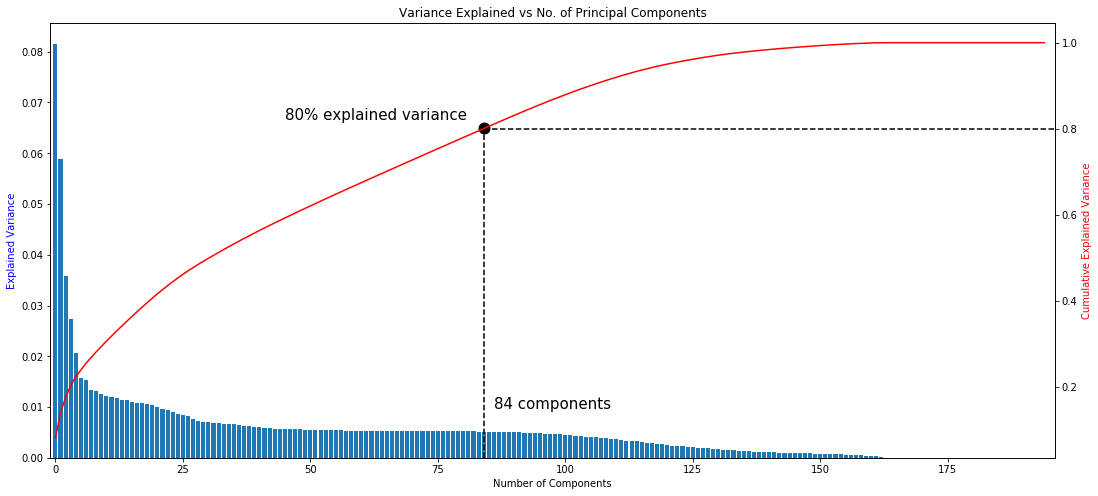

In [84]:
# Investigate the variance accounted for by each principal component.
components_total = len(pca.explained_variance_ratio_)
components = np.arange(components_total)

fig, ax1 = plt.subplots(figsize=(18,8))

ax1.bar(components,pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')
ax1.axvline(84, ls="--", color="black", ymax=0.75)
ax1.set_xlim(-1,196)

ax2 = ax1.twinx() 



ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red")
ax2.hlines(y=0.8,xmin=84,xmax=196,linestyles='dashed')
ax2.scatter(x = [84], y =[0.801], marker="o", linewidth=6.0, color="black")
ax2.text(45,0.82,"80% explained variance", fontsize=15, color="black")
ax2.text(86,0.15,"84 components", fontsize=15, color="black")
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Variance Explained vs No. of Principal Components")


# saving height of bars to collect individual component %
component_perct = []

for i in ax1.patches:
    component_perct.append(i.get_height())


In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca84 = PCA(n_components=84)
azdias_pca_84 = pca84.fit_transform(azdias_few_nans_enc1_impd_scld)


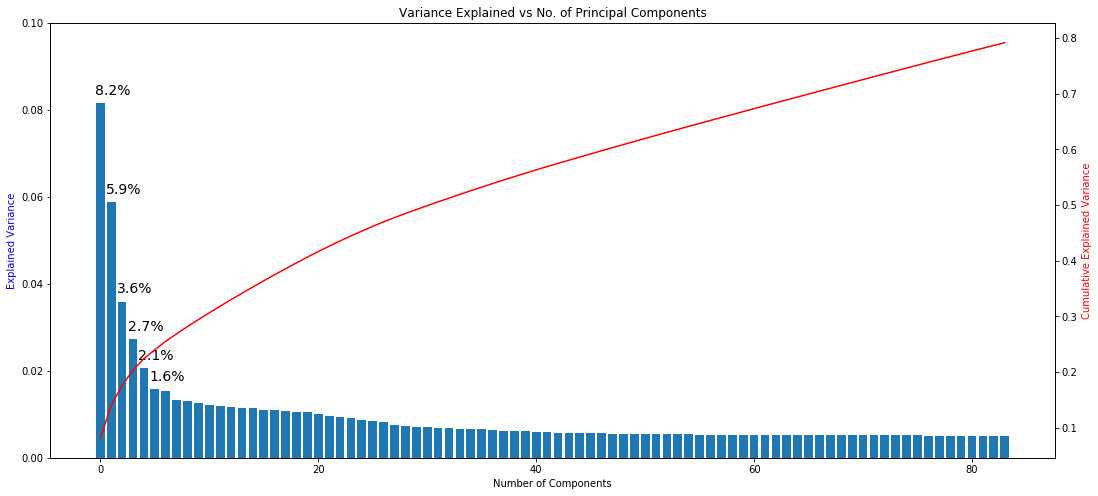

In [86]:
components_total = len(pca84.explained_variance_ratio_)
components = np.arange(components_total)

fig, ax1 = plt.subplots(figsize=(18,8))

ax1.bar(components,pca84.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 

#ax1.set_xlim(-1,72)
ax1.set_ylim(0,0.1)

ax2.plot(np.cumsum(pca84.explained_variance_ratio_), color="red")
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Variance Explained vs No. of Principal Components")

# annotate first 6 principle components with % values
for i,j in zip(ax1.patches[0:6],component_perct[0:6]):
    ax1.text(i.get_x()-.1, j+0.002,\
    str(round((j)*100, 1))+'%', fontsize=14)

### Discussion 2.2: Perform Dimensionality Reduction

After carrying out principle component analysis (PCA) on the data, the explained variance was plotted against the number of components. To maintain a good level of accuracy in the final model, I decided to pick a threshold of 80% for the total variance explained. This corresponded to a 84 principle components, with the first 6 components equating to approximately 24% of the total variance.

Therefore, I carried out PCA once more, transforming the data set into 84 principle components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [87]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_features(scaled_df, pca, component_perct, pc_num, tb_n=10):

    pca_df = pd.DataFrame(pca.components_,columns=scaled_df.columns,\
                 index = [f"PC-{i}" for i in range(1,len(pca.components_)+1)])

    sorted_df = pca_df.iloc[pc_num-1:pc_num,:].\
                sort_values(f"PC-{pc_num}", axis=1, ascending=True,inplace=False, kind='quicksort')    

    sorted_df.plot.bar(figsize=(14,6), legend=False)
    plt.ylabel('Feature Weights', fontsize=12)
    plt.xlabel('Principle Component', fontsize=12)
    plt.title(f'Explained Variance: {round(component_perct[pc_num-1]*100,1)}%', fontsize=12)

    highest_n = sorted_df.iloc[:,0:tb_n]
    lowest_n = sorted_df.iloc[:, -tb_n:]
    sorted_top_n = pd.concat([highest_n,lowest_n], axis=1)

    sorted_top_n.plot.bar(figsize=(14,6))
    plt.ylabel('Feature Weights', fontsize=12)
    plt.xlabel('Principle Component', fontsize=12)
    plt.title(f'Top and Bottom {tb_n} Features', fontsize=12)

In [88]:
def features_sorted(scaled_df, pca, pc_num=1):

    azdias_pca_df = pd.DataFrame(pca.components_,columns=scaled_df.columns,\
                 index = [f"PC-{i}" for i in range(1,len(pca.components_)+1)])

    sorted_df = azdias_pca_df.iloc[pc_num-1:pc_num,:].\
                sort_values(f"PC-{pc_num}", axis=1, ascending=True,inplace=False, kind='quicksort')  
        
    sorted_features = list(sorted_df.columns)
    print(f"Strongest +ve feature: {sorted_features[-1]},\nStrongest -ve feature: {sorted_features[0]}")
        
    return sorted_features

Strongest +ve feature: LP_STATUS_GROB_1.0,
Strongest -ve feature: MOBI_REGIO


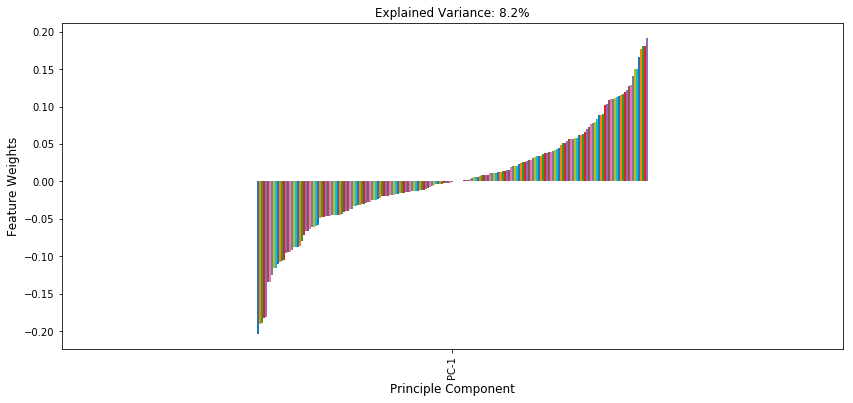

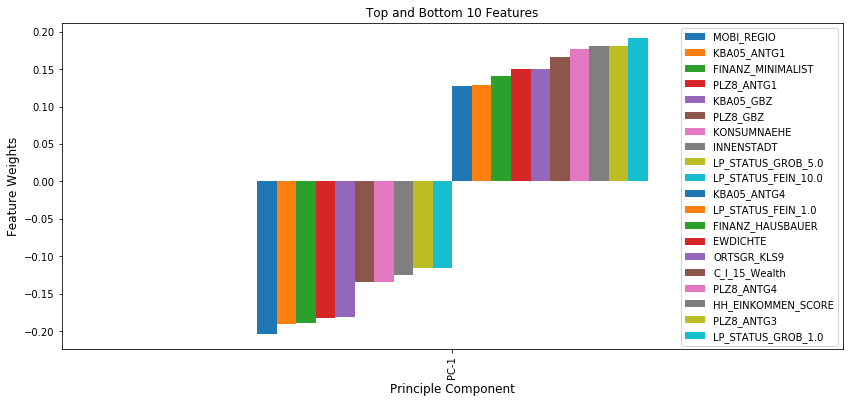

In [89]:
plot_features(azdias_few_nans_enc1_impd_scld, pca84,component_perct, pc_num=1, tb_n=10)
feats_pc1 = features_sorted(azdias_few_nans_enc1_impd_scld, pca84, pc_num=1)

Strongest +ve feature: ALTERSKATEGORIE_GROB,
Strongest -ve feature: P_J_Decade


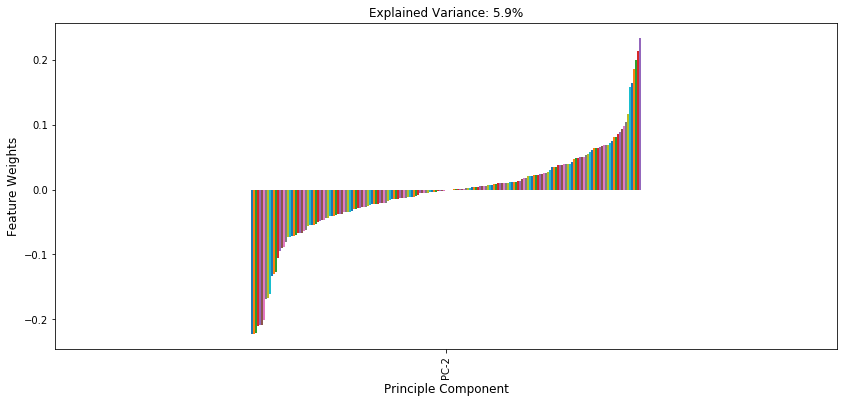

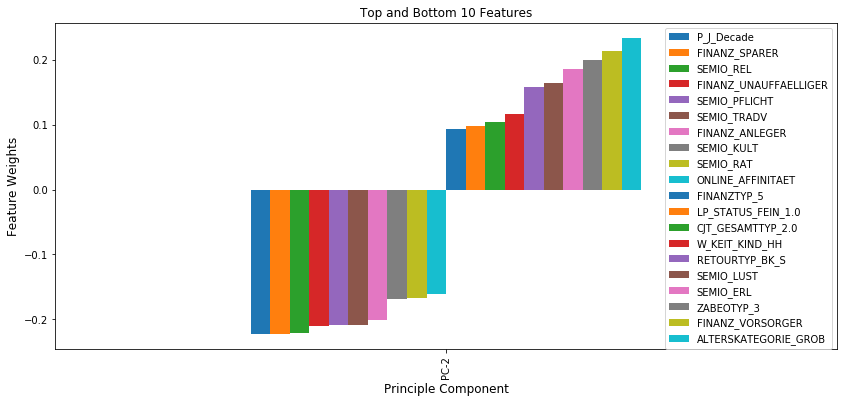

In [90]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_features(azdias_few_nans_enc1_impd_scld, pca84,component_perct, pc_num=2, tb_n=10)
feats_pc1 = features_sorted(azdias_few_nans_enc1_impd_scld, pca84, pc_num=2)


Strongest +ve feature: SEMIO_VERT,
Strongest -ve feature: ANREDE_KZ


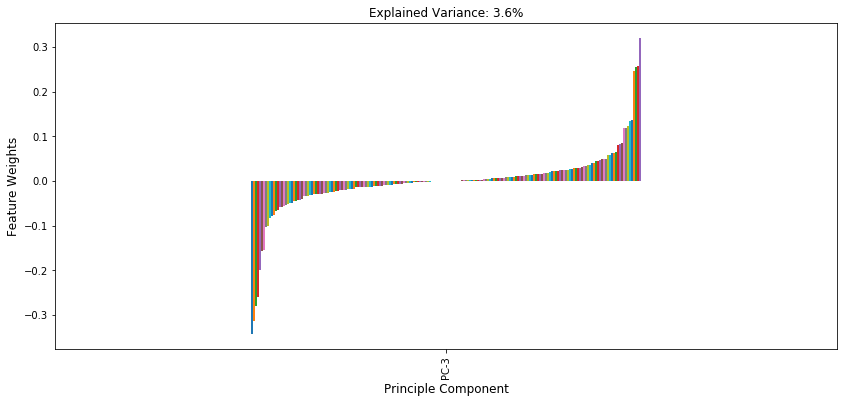

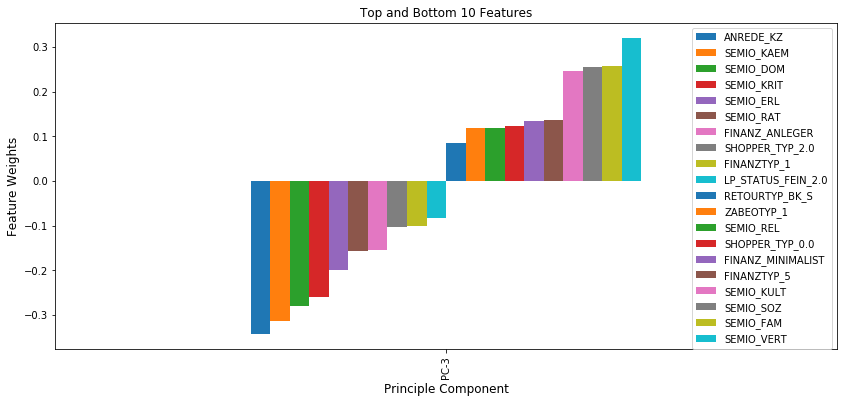

In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_features(azdias_few_nans_enc1_impd_scld, pca84,component_perct, pc_num=3, tb_n=10)
feats_pc1 = features_sorted(azdias_few_nans_enc1_impd_scld, pca84, pc_num=3)


### Discussion 2.3: Interpret Principal Components

1.)First principle component
Two strongest positive features (strongest first):
a.)LP_STATUS_GROB_1.0: Social status (rough scale); estimated household net income, 1.0 - low income earners
b.)PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region

Two strongest negative features (strongest first):
a.)MOBI_REGIO: Movement patterns
b.)KBA05_ANTG1: Number of 1-2 family houses in the microcell

For the strongest two positive features, a possible explanation for the positive correlation between them could be that low income areas are most likely to have a higher population density. A higher population density would then mean a larger number of family homes in a given region.

The strongest two negative features have a less obvious correlation. It could be that for one of the levels within MOBI_REGIO, i.e. "very high movement" corresponds to someone who lives in a remote and, therefore, less densely populated area, while needing to travel a lot (i.e. commute). Therefore, this may explain why somewhere with fewer family houses is correlated with a certain type of movement patterns.

Comparing the strongest positive and negative features, a source of negative correlation would very likely be between PLZ8_ANTG3 and KBA05_ANTG1, one representing a densely populated area while the other may represent a more sparsely populated area.

2.)Second principle component
Two strongest positive features (strongest first):
a.)ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
b.)FINANZ_VORSORGER: Financial typology, VORSORGER - be prepared

Two strongest negative features (strongest first):

a.)P_J_Decade: Generation by decade
b.)FINANZ_SPARER: Financial typology, SPARER - money-saver

For the stongest positive feature weights, again, there is no immediate factor linking the two. It is possible that different generations have different attititudes towards money, i.e. millienials may be more worried about saving compared to older generations. This could possibly cause a positive correlation between the two features.

The strongest negative feature weights show very similar properties to the two strongest negative features. It is possible that, the way the features have been encoded has resulted in a strong negative correlation as opposed to a strong positive correlation.

3.)Third principle component
Two strongest positive features (strongest first):
a.)SEMIO_VERT: Personality typology, VERT - dreamful
b.)SEMIO_FAM: Personality typology, FAM - family-minded
Two strongest negative features (strongest first):
a.)ANREDE_KZ: Gender
b.)SEMIO_KAEM: Personality typology, KAEM - combative attitude

In this principle component, the two strongest positive feature weights both refer to personality types. It is difficult to say a straight forward connection between dreamful and family-minded, however, maybe both of these personalities fall into a broader category i.e. peaceful.

The strongest negative features include gender and and a combative attitude. It is possible that, due to higher levels of testosterone, there is a higher proportion of males that have a combative attitude compared to females, which is causing the positive correlation between these features.

Comparing the strongest positive and negative features, it is understandable that there would be a negative corralation between comative personalities and people with family-minded/dreamy personalities, which is what we can see from this data.


In [92]:
azd_clean_scld_pca_df = pd.DataFrame(azdias_pca_84, \
                                     columns = [f"PC-{i}" for i in range(1,len(pca84.components_)+1)])
azd_clean_scld_pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-75,PC-76,PC-77,PC-78,PC-79,PC-80,PC-81,PC-82,PC-83,PC-84
0,4.853638,-3.814471,-3.334897,0.989370,0.847344,1.598916,-1.159438,-0.566178,1.268076,2.800631,...,-0.251423,0.495565,-0.582833,-0.179586,-0.172637,0.858330,-0.240061,-0.085149,0.414802,-0.926875
1,-0.502359,-0.652476,-3.391833,1.193033,-3.862196,1.012781,-1.375215,-0.769256,0.020677,-1.006242,...,-0.108585,0.205460,0.842036,0.599430,-0.341770,0.820820,-0.148327,0.048181,-0.834434,0.420876
2,-0.178109,0.234449,3.100320,1.022585,2.738231,1.596226,-4.119568,-0.863590,-2.415726,-3.614138,...,0.728345,-0.012415,-0.047540,-0.179826,0.079929,-0.026181,-0.299147,-0.955290,0.066067,0.189829
3,-0.613141,-1.002027,-1.353903,-3.380871,-2.229179,1.360082,-2.704640,-0.592576,0.907825,0.317969,...,-0.796709,0.005380,-0.138876,-0.932266,0.922782,-0.211037,0.780738,1.248545,0.304319,0.519831
4,0.894875,-4.218607,-3.412376,-1.494382,-2.145030,-1.073933,-0.354810,-1.730415,0.664715,0.136277,...,-0.219889,-0.439787,-0.330406,-0.466706,0.310815,-0.588191,-0.015262,-1.689803,1.274069,1.348008


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Text(0.5,1,'SSE vs. K')

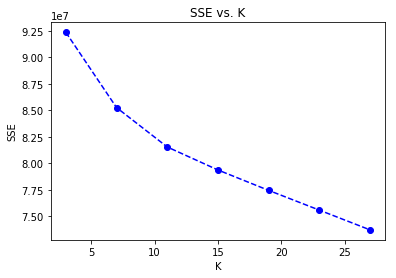

In [93]:

# Over a number of different cluster counts...


    # run k-means clustering on the data and...

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(3,30,4))

for center in centers:
    scores.append(get_kmeans_score(azd_clean_scld_pca_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')  
    
    # compute the average within-cluster distances.
    


In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=10, init='k-means++',  max_iter=500)
kmeans_fit = kmeans.fit(azd_clean_scld_pca_df)

# Attaching predictions to datafrae
azd_clean_scld_pca_df["labels"] = kmeans_fit.labels_

azd_clean_scld_pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-76,PC-77,PC-78,PC-79,PC-80,PC-81,PC-82,PC-83,PC-84,labels
0,4.853638,-3.814471,-3.334897,0.989370,0.847344,1.598916,-1.159438,-0.566178,1.268076,2.800631,...,0.495565,-0.582833,-0.179586,-0.172637,0.858330,-0.240061,-0.085149,0.414802,-0.926875,1
1,-0.502359,-0.652476,-3.391833,1.193033,-3.862196,1.012781,-1.375215,-0.769256,0.020677,-1.006242,...,0.205460,0.842036,0.599430,-0.341770,0.820820,-0.148327,0.048181,-0.834434,0.420876,8
2,-0.178109,0.234449,3.100320,1.022585,2.738231,1.596226,-4.119568,-0.863590,-2.415726,-3.614138,...,-0.012415,-0.047540,-0.179826,0.079929,-0.026181,-0.299147,-0.955290,0.066067,0.189829,6
3,-0.613141,-1.002027,-1.353903,-3.380871,-2.229179,1.360082,-2.704640,-0.592576,0.907825,0.317969,...,0.005380,-0.138876,-0.932266,0.922782,-0.211037,0.780738,1.248545,0.304319,0.519831,3
4,0.894875,-4.218607,-3.412376,-1.494382,-2.145030,-1.073933,-0.354810,-1.730415,0.664715,0.136277,...,-0.439787,-0.330406,-0.466706,0.310815,-0.588191,-0.015262,-1.689803,1.274069,1.348008,8


### Discussion 3.1: Apply Clustering to General Population

Multiple KMeans models have been fitted through a range of different values for the number of clusters. The sum of the squared errors (SSE) value was obtained though the "inertia_" attribute. This calculates the SSEs for the cluster center and the surrounding points. By plotting this versus the cluster size, it should become apparent the point at which additional clusters have a decreased benefit - visible from the so called "elbow" appearance of the graph.

In the plot above, the elbow is not the most distinct, but there is a clear shift in the rate at which SSE decreases in the range of 5 to 15 clusters. As each additional cluster provides a decreased benefit, I have decided to pick a number in the middle of the range and use 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [95]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")
#azdias_few_nans_enc1.shape

customers_preprocessed = clean_data(azdias_few_nans_enc1_impd_scld, customers, feat_info, 3)
customers_preprocessed.shape

(127437, 195)

In [96]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_preprocessed = clean_data(azdias_few_nans_enc1_impd_scld, customers, feat_info, 3)
# Carry out impuation 
customers_preprocessed_impd_arr = imp.transform(customers_preprocessed)

# Converting from array back to dataframe
customers_preprocessed_impd = pd.DataFrame(customers_preprocessed_impd_arr, columns = customers_preprocessed.columns)

# Transform dataset using trained StandardScaler
customers_preprocessed_impd_scld_arr = ss.transform(customers_preprocessed_impd)
# Converting from array back to dataframe
customers_preprocessed_impd_scld = pd.DataFrame(customers_preprocessed_impd_scld_arr, columns = customers_preprocessed.columns,\
                                                index = customers_preprocessed.index)

customers_preprocessed_impd_scld.head(n=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,P_J_Decade,P_J_Movement,C_I_15_Wealth,C_I_15_LS,WOHNLAGE_NBH,PLZ8_BAUMAX_HOMES,PLZ8_BAUMAX_BUSINESS,GEBAEUDETYP_5.0
0,1.164063,-1.025197,1.411386,-1.132765,1.113406,-1.236113,-0.407255,-0.834925,1.841624,-1.610388,...,-0.17991,-0.193076,23.863702,-2.843469,0.558311,-0.095249,0.007411,-0.8675,-1.290909,-0.378929


In [97]:
# Applying PCA
customer_pca_84 = pca84.transform(customers_preprocessed_impd_scld)

# Creating dataframe from PCA output
cust_clean_scld_pca_df = pd.DataFrame(customer_pca_84, \
                                      columns = [f"PC-{i}" for i in range(1,len(pca84.components_)+1)])

# Applying previously trained KMeans model to get predicted labels on customer data
###cust_clean_scld_pca_df["labels"] = kmeans.predict(cust_clean_scld_pca_df)

customer_predictions = kmeans.predict(cust_clean_scld_pca_df)

cust_clean_scld_pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-75,PC-76,PC-77,PC-78,PC-79,PC-80,PC-81,PC-82,PC-83,PC-84
0,-5.162497,3.669817,3.870612,0.995678,-1.262095,1.058568,-0.660273,-0.649178,3.480513,6.047362,...,3.202773,0.503680,1.511344,0.591962,-0.735408,0.842312,0.527405,-3.456939,0.654392,0.779944
1,-1.596607,6.298905,-1.546668,0.129115,-2.544866,-0.358637,2.833962,-0.380771,1.740697,0.657871,...,2.534350,4.918285,11.880286,-9.789528,4.913314,7.256098,3.181527,-0.469084,-3.478225,7.758928
2,1.580146,1.018122,1.017934,-0.820533,2.817500,3.645714,2.810156,-0.332387,4.051264,2.771872,...,4.364448,1.719589,1.408028,0.029930,-2.195838,1.365315,2.237321,-5.172791,3.197636,1.016083
3,-2.133788,2.349402,2.781146,0.621981,0.120134,3.735791,2.316572,-0.481374,-0.335106,5.254628,...,2.027503,2.182649,0.694482,0.878485,-2.477973,-0.471430,-0.428384,-2.684580,-0.009150,3.033535
4,-6.240827,2.121772,2.976462,0.523404,-1.011722,0.193963,-0.086137,0.034807,3.731781,6.642470,...,1.862505,0.224065,-0.386316,0.445741,-0.629819,-0.396033,1.191187,-3.315189,0.185341,-1.526162


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [98]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop_total_entries = azdias.shape[0]
cust_total_entries = customers.shape[0]

# Percentage of population clusters
population_label_counts  = list(azd_clean_scld_pca_df["labels"].value_counts()/pop_total_entries*100)

# Population cluster No.
# Adjusted by +0.8 so as to start numbering 
# at 1 then move population bars to the left
pop_labels = list(azd_clean_scld_pca_df["labels"].value_counts().index+0.85)


# Grouping labels and counts for customers
customer_labels_dict = Counter(customer_predictions)
customer_labels = list(customer_labels_dict.keys())
# Adding 1.15 to start clusters (labels) at 1 and
# to adjusting bar position on plot 
customer_labels_adj = [i + 1.15 for i in customer_labels]

# Percentage of population clusters
customer_label_counts = list(customer_labels_dict.values())
cust_label_perc = [(j/cust_total_entries*100) for j in customer_label_counts]


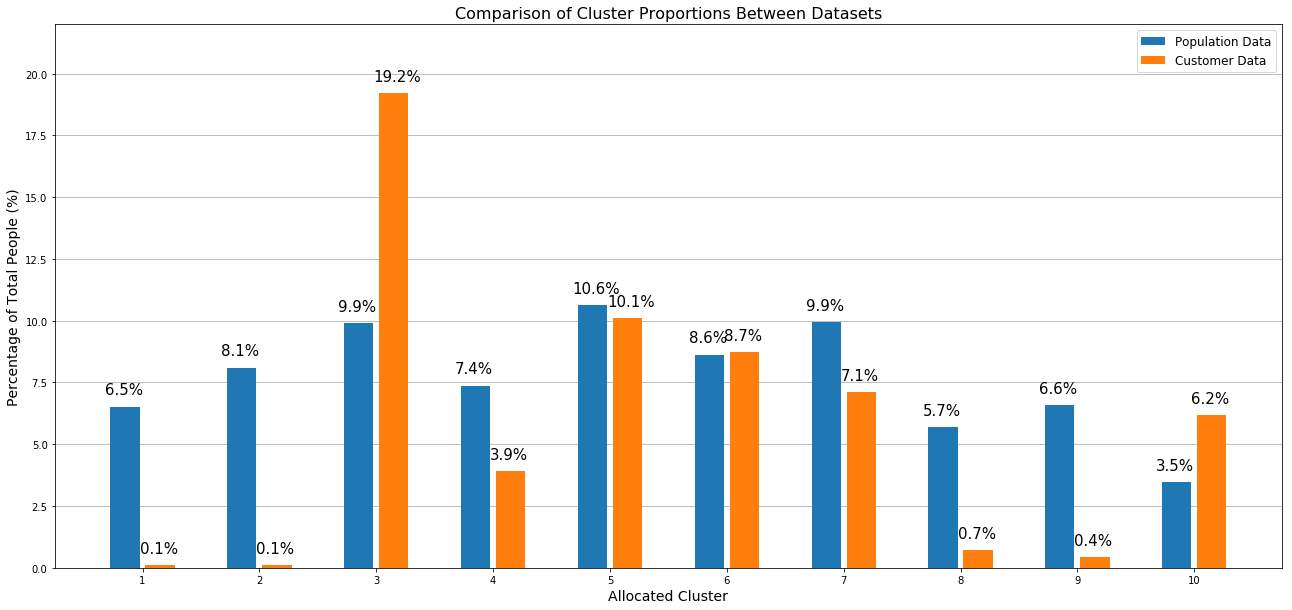

In [99]:
# Plotting clusters for population and customer datasets
fig, ax = plt.subplots(figsize = (22,10))

ax.bar(pop_labels,population_label_counts,width = 0.25,label='Population Data', zorder=3)
###ax.bar(cust_label_counts,customer_labels, width = 0.25, label='Customer Data', zorder=3)
ax.bar(customer_labels_adj,cust_label_perc, width = 0.25, label='Customer Data', zorder=3)


ax.yaxis.grid(zorder=0)
ax.set_ylim(0,22)
ax.set_ylabel('Percentage of Total People (%)', fontsize = 14)

ax.xaxis.set(ticks=range(1,11))
ax.set_xlabel('Allocated Cluster', fontsize = 14)

plt.title('Comparison of Cluster Proportions Between Datasets', fontsize = 16)
plt.legend(loc='best', fontsize=12)

# Collecting percentage data
component_perct_2 = []
for i in ax.patches:
    component_perct_2.append(i.get_height())

for i,j in zip(ax.patches,component_perct_2):
    ax.text(i.get_x()-.05, j+.5, str(round((j), 1))+'%', fontsize=15)

    
plt.show()

In [100]:
# Treating subset with high no. of NaNs as another cluster

# Calculating proportion in population proportion
population_entries = azdias.shape[0]
pop_few_nans_entries = azd_clean_scld_pca_df.shape[0]
pop_more_nans_entries = population_entries - pop_few_nans_entries

# Calculating proportion in population proportion
customer_entries = customers.shape[0]
cust_few_nans_entries = cust_clean_scld_pca_df.shape[0]
cust_more_nans_entries = customer_entries - cust_few_nans_entries

# Converting to percentages
pop_more_nans_entr_perc = pop_more_nans_entries/population_entries * 100
cust_more_nans_entr_perc = cust_more_nans_entries/customer_entries * 100

# Adding results to lists for plotting
demographic = ['Population', 'Customers']
perc_of_demog = [pop_more_nans_entr_perc, cust_more_nans_entr_perc]

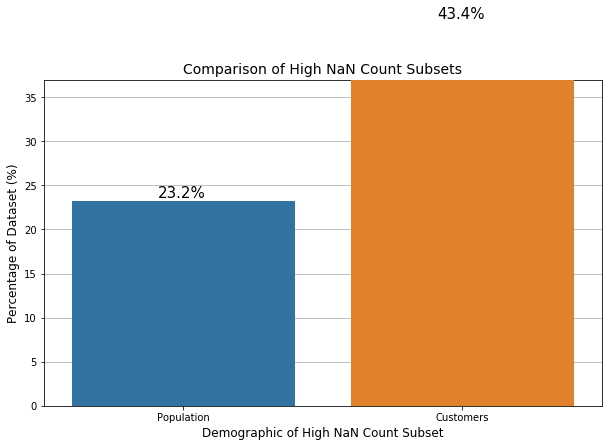

In [101]:
# Plotting proportion of high NaN count subset
# for population and customer demographics

fig, ax = plt.subplots(figsize = (10,6))

sns.barplot(demographic,perc_of_demog, ax = ax, zorder=3)

ax.yaxis.grid(zorder=0)
ax.set_ylim(0,37)
ax.set_ylabel('Percentage of Dataset (%)', fontsize = 12)

ax.set_xlabel('Demographic of High NaN Count Subset', fontsize = 12)

plt.title('Comparison of High NaN Count Subsets', fontsize = 14)


#Collecting percentage data
component_perct_2 = []
for i in ax.patches:
    component_perct_2.append(i.get_height())

for i,j in zip(ax.patches,component_perct_2):
    ax.text(i.get_x()+.31, j+.5, str(round((j), 1))+'%', fontsize=15)

    
plt.show()

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Obtaining cluster centroids and related PC strengths
centroids_pcs = kmeans.cluster_centers_
centroids_pcs_df = pd.DataFrame(centroids_pcs, columns = cust_clean_scld_pca_df.columns)

# Cluster 3  (index = 2) is over-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
centroids_pcs_df.loc[0:3,:].sort_values(by = 2,axis=1, ascending = False).head(n=3)

,PC-4,PC-3,PC-2,PC-9,PC-15,PC-18,PC-23,PC-14,PC-32,PC-36,...,PC-12,PC-16,PC-11,PC-19,PC-22,PC-7,PC-21,PC-5,PC-6,PC-1
0,-0.448854,2.633876,-2.837598,0.483924,0.136994,-0.119318,-0.261739,0.190826,0.083892,0.172012,...,-0.106131,-0.238299,-0.174389,-0.182709,0.051480,-0.208849,-0.033007,0.002221,-0.231661,4.988295
1,0.866741,-2.666370,-2.258544,0.379234,-0.080574,-0.003596,0.209129,0.034736,0.023460,0.109030,...,-0.093154,0.011227,0.663509,-0.050238,-0.334256,-0.063444,0.012197,-0.130378,-0.444391,5.126262
2,3.090440,0.847391,0.615883,0.521723,0.488355,0.430453,0.360651,0.248988,0.199846,0.170506,...,-0.262069,-0.291412,-0.352142,-0.429222,-0.441669,-0.477414,-0.774474,-0.797060,-1.449433,-4.694877


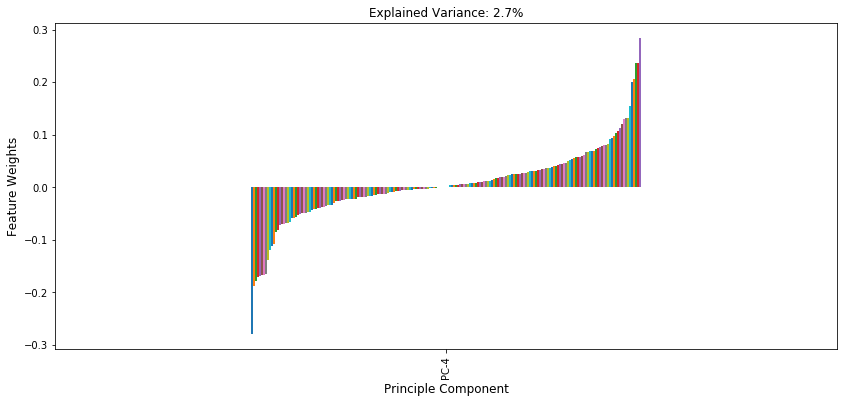

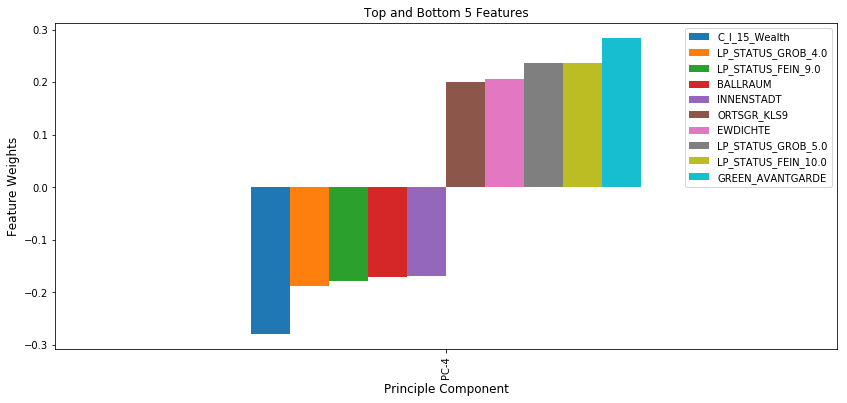

In [103]:
# Investgating related features to 4th principal component ("PC-4")
plot_features(customers_preprocessed, pca84,component_perct, pc_num=4, tb_n=5)

In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster 5 (index = 4) is under-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
centroids_pcs_df.loc[4:5,:].sort_values(by = 4,axis=1, ascending = False).head(n=1)


,PC-5,PC-7,PC-11,PC-17,PC-2,PC-19,PC-16,PC-33,PC-28,PC-12,...,PC-3,PC-14,PC-9,PC-18,PC-23,PC-26,PC-15,PC-6,PC-4,PC-1
4,1.196397,0.903291,0.669262,0.592351,0.513592,0.461742,0.28197,0.241915,0.231732,0.196171,...,-0.243776,-0.263582,-0.371989,-0.431746,-0.529414,-0.53506,-0.674415,-0.847487,-2.30477,-4.185912


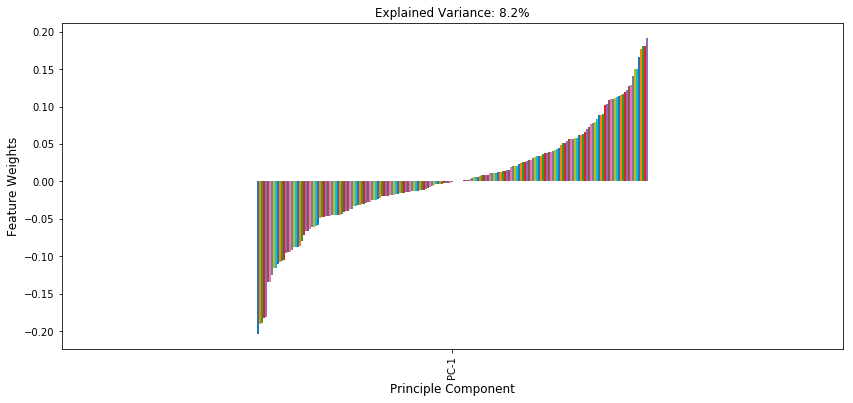

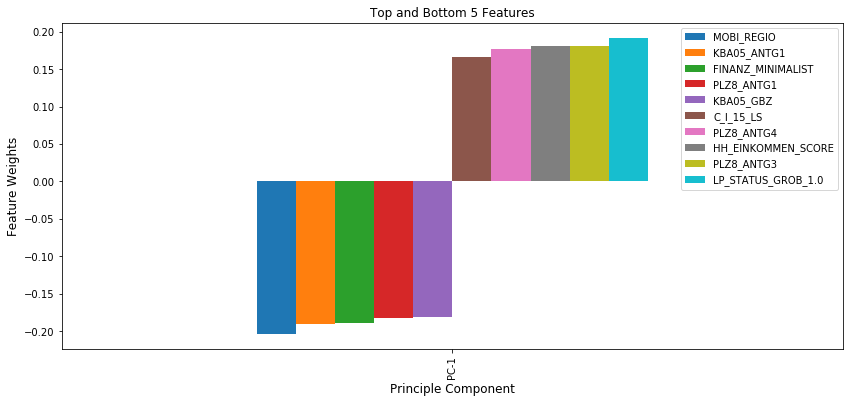

In [106]:
# The 1st principal component has the strongest association
# with the fifth cluster

# Investgating related features to 1st principal component ("PC-1")
plot_features(customers_preprocessed, pca84,component_perct, pc_num=1, tb_n=5)

In [107]:
# Calculating mean movement pattern
print(customers_preprocessed['MOBI_REGIO'].mean())
print(azdias_few_nans_enc1['MOBI_REGIO'].mean())

3.6211816572
2.99652886332


In [108]:
# Calculating mean value for LP_STATUS_GROB_1.0
print(customers_preprocessed['LP_STATUS_GROB_1.0'].mean()/191652)
print(azdias_few_nans_enc1['LP_STATUS_GROB_1.0'].mean()/891211)

7.006365107e-07
4.5148340436e-07


### Discussion 3.3: Compare Customer Data to Demographics Data
Following cluster analysis, there appears to be a few noticeable difference between the clustering of the two demographics. To make inferences about the people type related to the clusters, the centroids were mapped back to the corresponding principal (PC) components. These were then ranked in descending order so the the PC with the strongest association could be chosen. The features corresponding to this PC could then be found by using the previous mapping of PCs to features. It is worth noting that the values for explained variance are for the previous mapping and are not accurate for the customer data.
Popular segments

After observing a significant amount of over-representation (approx. 9%) for the number 3 labeled cluster, the following two features were found to have the strongest association:

1.)C_I_15_Wealth: This was an engineered variable from an existing mixed variable (CAMEO_INTL_2015). It distinguishes a persons' level of wealth.

2.)GREEN_AVANTGARDE: "Membership in environmental sustainability as part of youth"

Here, the first feature looks like a reasonable result since the mail order company relies on people buying goods. From calculating the mean value for this feature and referring to the feature dictionary, it shows that it is likely the customer demographic has a higher mean wealth which could be evidence of the connection to this feature.

The second feature is less obvious. It is possible that people concerned with environmental sustainability are less likely to use a mail order service in order to reduce waste packaging.

Unpopular segments:

The two features related to the under-representation of the general population in the customer dataset were found to be those described in the first principle component which were described previously (MOBI_REGIO and LP_STATUS_GROB_1.0). These correspond to customers with a low income or a particular movement pattern.

Interestingly, comparing the customer sample to the population, it appears that people with a higher movement pattern are more likely to use a mail order service (due to the higher calculated mean) judging from this association. The customer sample also seems to have a higher proportion of low-income earners.

Missing values subset:

Comparing the proportions of missing values, it is apparent there is a clear difference present. To extend this project, it would be good to carry out clustering again on just the subset with a higher amount of NaNs and on the whole dataset - i.e. not removing these values at all. If the resulting clustering significantly changes while investigating these options, it may be worth treating high proportion of NaNs as separate datasets, as it would be likely they contain extra information about customer segments that would be missed if not included.

Future avenues:

It would be nice to try different clustering algorithms for this project and compare the consistency between them. It would also be interesting to utilise different types of encoding and scalers, as well as different cut--offs for the number of missing values, to again investigate how this effects the clustering result.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.